# **Step 3:** Calibration and Error Estimation

# Introduction - what does this notebook do?
In this notebook, we will for one of your trained <nobr>Micro$\mathbb{S}$plit</nobr> models asses ***how well predicted unmixed channel images are calibrated and how we can estimate the true error of these predictions***. 

This is quite useful, since it allows users of <nobr>Micro$\mathbb{S}$plit</nobr> to identify which parts of the data are likely not fit biological downstream analyses -- if even the network that produced them was not sure what to predict, how could you ever trust these predictions? Quite logical and also quite cool that this possibility exists, isn't it?

## What is a 'calibrated' network?
We call a trained network *calibrated* when its own assessment of how off it's predictions are scales with how off they really are. Or, in other words, whenever its predicted uncertainty aligns with the true prediction error. We will soon see what that really means and how we can assess calibration and estimate prediciton errors.

**More specifically, in this notebook we will:**
1. use saved MMSE predictions, pixel-wise posterior sample standard deviations, and target images we did not use during training to calibrate an error estimator, and then
1. generate calibration plots and learn how to interpret them, and
1. compute uncertainty maps that can point users at predicted images or parts of predicted images that likely contain unreliable predictions, to finally
1. check how the true error (wrt. to potentially noisy target data) compares to the pixel-wise variability between posterior samples.

In [1]:
import os
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import pooch

from careamics.lvae_training.calibration import (
    Calibration,
    plot_calibration,
)

# Reality check: did you generate all the needed data?

In the the previous notebook `02_predict.ipynb` we leaned how to make predictions on data that was not part of the training data (ie. the Validation and Test data).

For both chunks of data, Validation and Test, we should have saved three files, containing *(i)* MMSE predictions, *(ii)* pixel-wise standard deviations between posterior samples that created the MMSE results, and  *(iii)* corresponding high-SNR data (which we created by using a very long exposure time while imaging).

We expect this data to reside in a folder called `calibration_data/XXms`, where `XX` is the exposure time in ms of the part of the *HT_LIF24* data you chose to use in previous notebooks. Here an example of how this should look like:
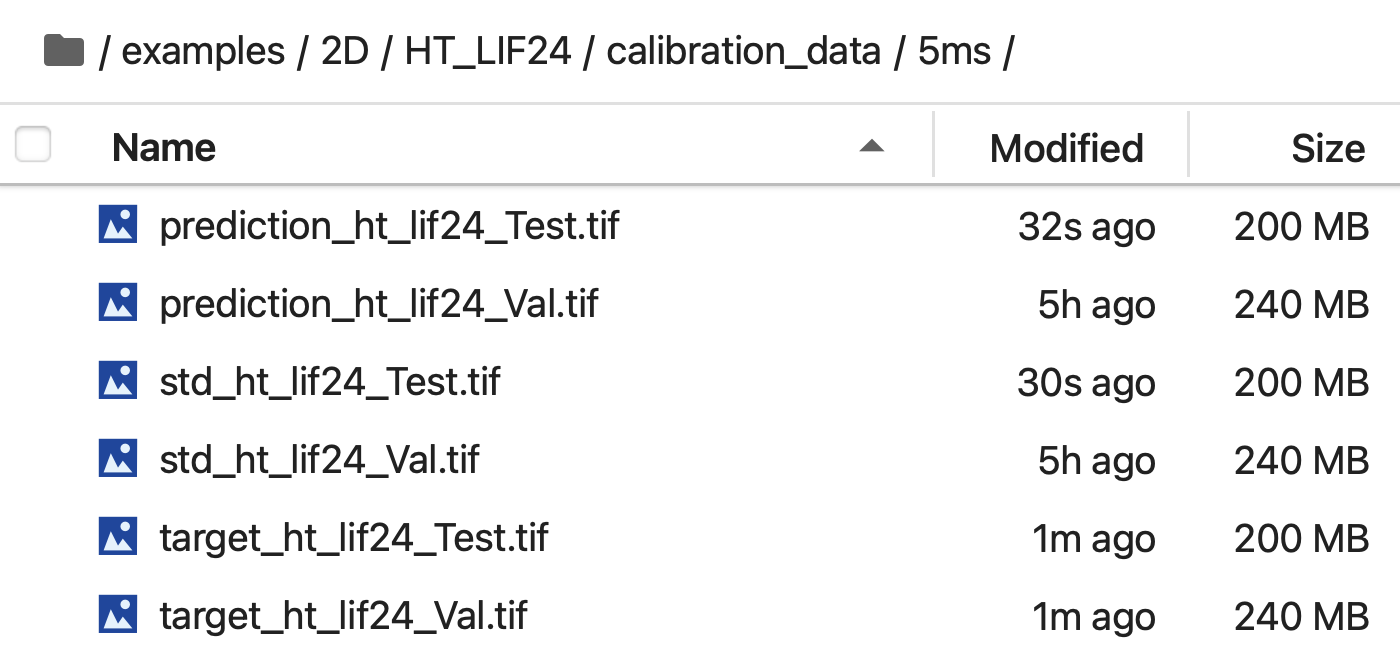

# **Step 3.1:** Load and Prepare the Data

### Set path to your data prefix

In [2]:
# change this if you changed it in the 02_predict notebook
dataset_prefix = "custom_dataset_"  # TODO: fill in with your own dataset prefix

**Check if required files exist and load them...**

In [3]:
calib_data_dir = f"calibration_data"
assert os.path.exists(calib_data_dir)

# Load data triplet for Validation data portion...
pred_val_fname = os.path.join(calib_data_dir, f"prediction_{dataset_prefix}Val.tif")
std_val_fname = os.path.join(calib_data_dir, f"std_{dataset_prefix}Val.tif")
target_val_fname = os.path.join(calib_data_dir, f"target_{dataset_prefix}Val.tif")
assert os.path.exists(
    pred_val_fname
), f"File containing MMSE Predictions ({pred_val_fname}) not found. Run the `02_predict.ipynb` on the Validation data and save this file (as instructed in the notebook)."
assert os.path.exists(
    std_val_fname
), f"File containing the pixel-wise std values of posterior samples ({std_val_fname}) not found. Run the `02_predict.ipynb` on the Validation data and save this file (as instructed in the notebook)."
assert os.path.exists(
    target_val_fname
), f"File containing training-data like target data ({target_val_fname}) not found. Run the `02_predict.ipynb` and save this file (as instructed in the notebook)."
pred_val = tifffile.imread(pred_val_fname)
std_val = tifffile.imread(std_val_fname)
target_val = tifffile.imread(target_val_fname)

# Load data triplet for Test data portion...
pred_test_fname = os.path.join(calib_data_dir, f"prediction_{dataset_prefix}Test.tif")
std_test_fname = os.path.join(calib_data_dir, f"std_{dataset_prefix}Test.tif")
target_test_fname = os.path.join(calib_data_dir, f"target_{dataset_prefix}Test.tif")
assert os.path.exists(
    pred_test_fname
), f"File containing MMSE Predictions ({pred_test_fname}) not found. Run the `02_predict.ipynb` on the Test data and save this file (as instructed in the notebook)."
assert os.path.exists(
    std_test_fname
), f"File containing the pixel-wise std values of posterior samples ({std_test_fname}) not found. Run the `02_predict.ipynb` on the Test data and save this file (as instructed in the notebook)."
assert os.path.exists(
    target_test_fname
), f"File containing training-data like target data ({target_test_fname}) not found. Run the `02_predict.ipynb` and save this file (as instructed in the notebook)."
pred_test = tifffile.imread(pred_test_fname)
std_test = tifffile.imread(std_test_fname)
target_test = tifffile.imread(target_test_fname)

print("✅ if you see no errors, all required data is now loaded!")

✅ if you see no errors, all required data is now loaded!


# **Step 3.2:** Compute calibration using Validation data
In order to evaluate how calibrated our network is we must compare the variability between posterior samples at any pixel with the true error of these pixel predictions with respect to high-SNR 'ground truth'. For this we will load the posterior samples we predicted on the ***validation data*** we did not use during model training.

In [4]:
calib = Calibration(
    num_bins=50,
)
native_stats = calib.compute_stats(pred=pred_val, pred_std=std_val, target=target_val)
count = np.array(native_stats[0]["bin_count"])
count = count / count.sum()

# _,ax = plt.subplots(figsize=(5,5))
# plt.title("Val. data RMV vs. RMSE - NOT CALIBRATED!")
# plot_calibration(ax, native_stats)

# Compute calibration factors for the channels
calib_factors, factors_array = calib.get_calibrated_factor_for_stdev()
print(f"Calibration factors: {calib_factors}")

/localscratch/micromamba/envs/careamics/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/localscratch/micromamba/envs/careamics/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Calibration factors: {0: {'scalar': 2.8167358297662353, 'offset': 0.34568732356726517}, 1: {'scalar': 3.2651411294882196, 'offset': 0.555552915186436}}


# **Step 3.3:** Use calibration setting computed on Validation data and check how calibrated the Test data is

Once we know how the inter-sample variability (*ie.* RMV) relates to the true error (*ie.* RMSE), we would like to predict the error <nobr>Micro$\mathbb{S}$plit</nobr> makes on our ***test data***, wich we did not use for computing the calibration above (we used the validation data for that).

Compute calibration for validation data...

/localscratch/micromamba/envs/careamics/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


✅
Compute calibration for test data...✅
Plotting results...


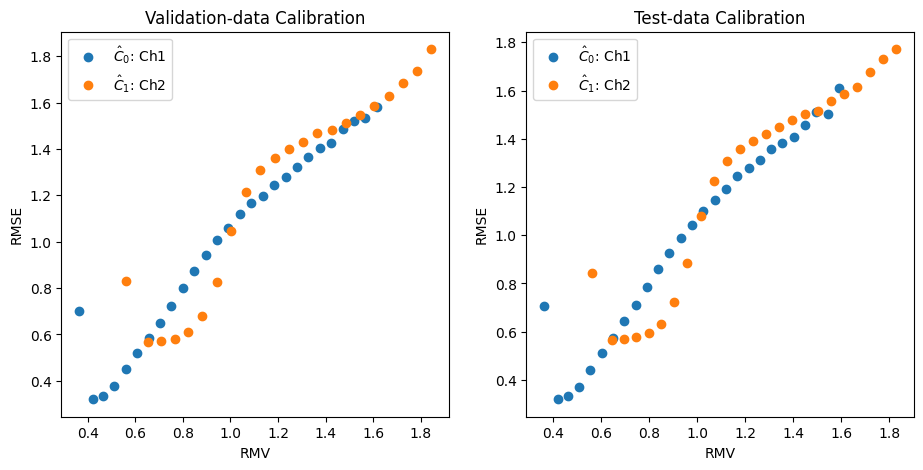

In [5]:
# Use calibration factor we previously computed on the Validation data...

# ...on the validation data
print("Compute calibration for validation data...", end="")
calib_val = Calibration(num_bins=50)
stats_val = calib_val.compute_stats(
    pred_val, std_val * factors_array["scalar"] + factors_array["offset"], target_val
)
print("✅")

# ...on the test data
print("Compute calibration for test data...", end="")
calib_test = Calibration(num_bins=50)
stats_test = calib_test.compute_stats(
    pred_test, std_test * factors_array["scalar"] + factors_array["offset"], target_test
)
print("✅")

# Finally, plotting the results!
print("Plotting results...")
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))

# _,ax = plt.subplots(figsize=(5,5))
# plt.title("Test-data Calibration")
ax[0].set_title("Validation-data Calibration")
plot_calibration(ax[0], stats_val)

# _,ax = plt.subplots(figsize=(5,5))
# plt.title("Test-data Calibration")
ax[1].set_title("Test-data Calibration")
plot_calibration(ax[1], stats_test)

### So, what do we see above?
On the **x-axis** we plot the [root-mean-variance (RMV)](https://pubs.aip.org/aip/aml/article/1/4/046121/2930395/Calibration-in-machine-learning-uncertainty) between the posterior samples we computed in the notebook `02_predict.ipynb` and stored in the `calibration_data` folder.
On the **y-axis** we plot the [root-mean-squared-error (RMSE)](https://en.wikipedia.org/wiki/Root_mean_square_deviation) between the MMSE predictions we also computed in the predictiion notebook and the (potentially even noisy) target data, also both stored in the `calibration_data` folder.

If the RMV between posterior samples would perfectly scale with the true error (measured via RMSE), the plots (one for each of the two predicted channels) would perfectly lie on the diagonal $y=x$. Now, this is not the case, but it is not all to far off, which is good news!

# **Step 3.4:** Plotting estimated true error (RMSE maps)
This will help you to spot parts in predictions made my <nobr>Micro$\mathbb{S}$plit</nobr> you should probably not rely on.

***Note:*** The standard deviation maps, eg. `std_test`, are the uncertainty maps mentioned in our paper. Below, we plot a scaled version of these maps, such that their values also predict the **true error**. This scaling is determined by the calibration we computed above on the validation set (and is here applied to the test set).

Intensity stats for Channel 1:
 > Prediciton (min, max): (-2.444,16.473)
 > Target (min, max):     (-3.721,28.117)
 > RMSE (min, max):       ( 0.346, 2.696)
Intensity stats for Channel 2:
 > Prediciton (min, max): (-3.945, 5.742)
 > Target (min, max):     (-5.816,16.989)
 > RMSE (min, max):       ( 0.346, 2.686)


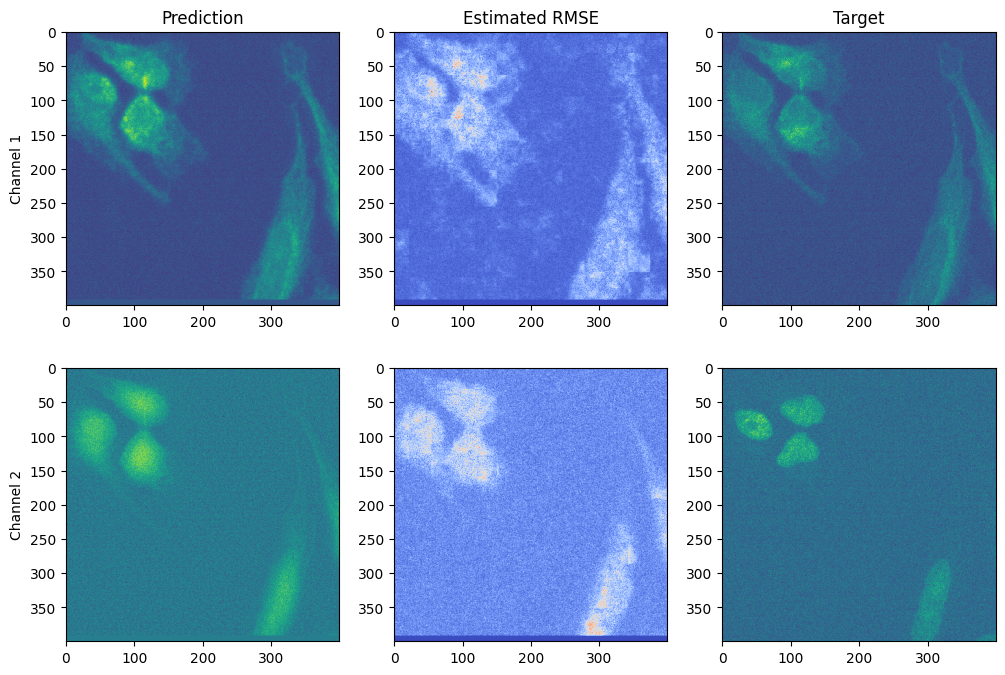

In [6]:
# Compute the predicted true error
pred_error_test = (
    std_test * factors_array["scalar"].squeeze()[0]
    + factors_array["offset"].squeeze()[0]
)

_, ax = plt.subplots(figsize=(12, 8), ncols=3, nrows=2)
hs = 1200
ws = 250
sz = 400
ax[0, 0].imshow(pred_test[0, hs : hs + sz, ws : ws + sz, 0])
ax[0, 1].imshow(pred_error_test[0, hs : hs + sz, ws : ws + sz, 0], cmap="coolwarm")
ax[0, 2].imshow(target_test[0, hs : hs + sz, ws : ws + sz, 0])

ax[1, 0].imshow(pred_test[0, hs : hs + sz, ws : ws + sz, 1])
ax[1, 1].imshow(pred_error_test[0, hs : hs + sz, ws : ws + sz, 1], cmap="coolwarm")
ax[1, 2].imshow(target_test[0, hs : hs + sz, ws : ws + sz, 1])

ax[0, 0].set_title("Prediction")
ax[0, 1].set_title("Estimated RMSE")
ax[0, 2].set_title("Target")
ax[0, 0].set_ylabel("Channel 1")
ax[1, 0].set_ylabel("Channel 2")

print("Intensity stats for Channel 1:")
print(
    f" > Prediciton (min, max): ({pred_test[...,0].min():6.3f},{pred_test[...,0].max():6.3f})"
)
print(
    f" > Target (min, max):     ({target_test[...,0].min():6.3f},{target_test[...,0].max():6.3f})"
)
print(
    f" > RMSE (min, max):       ({pred_error_test[...,0].min():6.3f},{pred_error_test[...,0].max():6.3f})"
)
print("Intensity stats for Channel 2:")
print(
    f" > Prediciton (min, max): ({pred_test[...,1].min():6.3f},{pred_test[...,1].max():6.3f})"
)
print(
    f" > Target (min, max):     ({target_test[...,1].min():6.3f},{target_test[...,1].max():6.3f})"
)
print(
    f" > RMSE (min, max):       ({pred_error_test[...,1].min():6.3f},{pred_error_test[...,1].max():6.3f})"
)

In [7]:
diff_pred_target = np.abs(pred_test - target_test) ** 2
true_L2_error = np.sqrt(np.mean(diff_pred_target))
estimated_L2_error = np.mean(pred_error_test)

print(f"Esimated error: {estimated_L2_error:8.2f}")
print(f"True error:     {true_L2_error:8.2f}")
print(f"Difference:     {np.abs(estimated_L2_error-true_L2_error)}")

Esimated error:     0.53
True error:         0.59
Difference:     0.0645264983177185


### Congratulations, you reached the end! What an accomplishment! 🥇